In [241]:
%matplotlib widget

from experiments import Experiment, _DefaultFloatLogSlider, _DefaultIntSlider

from translocation_models import TranslocationModel, \
    SC2R, SC2R2Loops, DefectiveSC2R, \
    DiscSpiral, DefectiveDiscSpiral

from ipywidgets import Widget, FloatLogSlider, IntSlider, \
    HBox, VBox, HTML, Output, Layout
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.transforms import Affine2D
import pandas as pd
from pandas import DataFrame
import matplotlib as mpl


In [248]:
class SC2RDiscSpiralComparison(Experiment):
    def __init__(self):
        self._sc2r = SC2R()
        self._disc_spiral = DiscSpiral()
        super().__init__()

    def _construct_free_parameters(self) -> dict[str, Widget]:
        return {
            'atp_adp_ratio': _DefaultFloatLogSlider(
                value=1e2, min=0, max=4, readout_format='.1e',
                description="[ATP]/[ADP]:"),
            'equilibrium_atp_adp_ratio': _DefaultFloatLogSlider(
                value=1e-5, min=-7, max=-3, readout_format='.1e',
                description="([ATP]/[ADP])|eq.:"),
            'K_d_atp': _DefaultFloatLogSlider(
                value=0.1, description="K_d^ATP:"),
            'K_d_adp': _DefaultFloatLogSlider(description="K_d^ADP:"),
            'k_DT': _DefaultFloatLogSlider(description="k_DT:"),
            'k_h': _DefaultFloatLogSlider(description="k_h:"),
            'k_s': _DefaultFloatLogSlider(value=0.1, description="k_s:"),
            'k_up': _DefaultFloatLogSlider(description="k_↑:"),
            'n_protomers': _DefaultIntSlider(description="n_protomers:"),
            'k_extended_to_flat_up': _DefaultFloatLogSlider(description="k_⮫:"),
            'k_flat_to_extended_down': _DefaultFloatLogSlider(description="k_⮯:"),
            'k_flat_to_extended_up': _DefaultFloatLogSlider(description="k_⮭:"),
        }

    def _construct_constrained_parameters(self) -> dict[str, Widget]:
        return {
            'k_TD': HTML(description="k_TD:"),
            'k_down': HTML(description="k_↓:"),
            'k_h_bar': HTML(description="ꝁ_h:"),
            'k_flat_to_extended_down_bar': HTML(description="ꝁ_⮯:"),
            'k_extended_to_flat_down': HTML(description="k_⮩:"),
        }

    def _construct_gui(self) -> Widget:
        gui_plot = Output()
        gui_parameters = VBox([
            HTML(value="<h1>SC/2R and Disc-Spiral ATP consumption rate comparison</h1>"),

            HTML(value="<b>General Physical Parameters</b>"),
            HBox([self._free_parameters['atp_adp_ratio'],
                  HTML(value="ATP/ADP concentration ratio")]),
            HBox([self._free_parameters['equilibrium_atp_adp_ratio'],
                  HTML(value="Equilibrium ATP/ADP concentration ratio")]),
            HBox([self._free_parameters['K_d_atp'],
                  HTML(value="Protomer-ATP dissociation constant")]),
            HBox([self._free_parameters['K_d_adp'],
                  HTML(value="Protomer-ADP dissociation constant")]),
            HBox([self._free_parameters['k_DT'],
                  HTML(value="Effective ADP->ATP exchange rate")]),
            HBox([self._constrained_parameters['k_TD'],
                  HTML(value="Effective ATP->ADP exchange rate "
                       "(constrained by Protomer-ATP/ADP exchange model)")]),
            HBox([self._free_parameters['k_h'],
                  HTML(value="ATP Hydrolysis rate")]),
            HBox([self._free_parameters['k_s'],
                  HTML(value="ATP Synthesis rate")]),

            HTML(value="<b>SC2R Model Physical Parameters</b>"),
            HBox([self._free_parameters['k_up'],
                  HTML(value="Translocation up rate")]),
            HBox([self._constrained_parameters['k_down'],
                  HTML(value="Translocation down rate "
                       "(constrained by detailed balance)")]),

            HTML(value="<b>Disc-Spiral Model Physical Parameters</b>"),
            HBox([self._free_parameters['n_protomers'],
                  HTML(value="Number of protomers")]),
            HBox([self._constrained_parameters['k_h_bar'],
                  HTML(value="Effective ATP hydrolysis rate")]),
            HBox([self._free_parameters['k_extended_to_flat_up'],
                  HTML(value="Spiral->disc up translocation rate")]),
            HBox([self._free_parameters['k_flat_to_extended_down'],
                  HTML(value="Disc->spiral down translocation rate")]),
            HBox([self._constrained_parameters['k_flat_to_extended_down_bar'],
                  HTML(value="Effective disc->spiral down translocation rate")]),
            HBox([self._free_parameters['k_flat_to_extended_up'],
                  HTML(value="Disc->spiral up translocation rate")]),
            HBox([self._constrained_parameters['k_extended_to_flat_down'],
                  HTML(value="Spiral->disc down rate "
                       "(constrained by detailed balance)")]),
        ])

        gui = HBox([gui_plot, gui_parameters],
                   layout=Layout(align_items='center'))

        return gui

    def _run(self) -> None:
        # Update GUI<->Models
        models = [self._sc2r, self._disc_spiral]
        self._update_models_free_parameters(models, self._free_parameters)
        self._update_gui_constrained_parameters(models,
                                                self._constrained_parameters)

        # Normalize average velocity
        for model in models:
            model.normalize_average_velocity(inplace=True)
        assert np.isclose(self._sc2r.average_velocity(),
                          self._disc_spiral.average_velocity())

        # For both model, we do a few trajectories, compute analytical stats and
        # empirical stats, and then plot everything.
        plot_trajectories = True
        plot_analytical_stats = True
        plot_empirical_stats = True
        times = np.linspace(0, 100, 100)
        n_trajectories = 1

        if plot_trajectories:
            sc2r_trajectories = self._sc2r.gillespie(
                max_time=times[-1],
                n_simulations=n_trajectories,
                cumulative_sums='position')
            disc_spiral_trajectories = self._disc_spiral.gillespie(
                max_time=times[-1],
                n_simulations=n_trajectories,
                cumulative_sums='position')
            if isinstance(sc2r_trajectories, DataFrame):
                sc2r_trajectories = [sc2r_trajectories]
            if isinstance(disc_spiral_trajectories, DataFrame):
                disc_spiral_trajectories = [disc_spiral_trajectories]

        if plot_analytical_stats:
            sc2r_analytical_position_stats = \
                self._sc2r.analytical_attribute_stats(
                    'position', times=times)
            disc_spiral_analytical_position_stats = \
                self._disc_spiral.analytical_attribute_stats(
                    'position', times=times)
                
        if plot_empirical_stats:
            n_simulations = 100
            sc2r_empirical_position_stats = \
                self._sc2r.empirical_attribute_stats(
                    'position', times=times, n_simulations=n_simulations)
            disc_spiral_empirical_position_stats = \
                self._disc_spiral.empirical_attribute_stats(
                    'position', times=times, n_simulations=n_simulations)
        
        # Plot everything
        gui_plot = self._gui.children[0]
        with gui_plot:
            gui_plot.clear_output(wait=True)
            plt.close('SC2RDiscSpiralComparison')
            fig = plt.figure('SC2RDiscSpiralComparison')
            fig.canvas.header_visible = False
            fig.canvas.footer_visible = False
            fig.canvas.toolbar_visible = False
            ax = fig.add_subplot(111)

            yellow = '#DDAA33'
            blue = '#004488'
            alpha_0_2 = '33'
            alpha_0_5 = '80'
            hidden = '#00000000'
            if plot_analytical_stats:
                sc2r_fill_between = ax.fill_between(
                    sc2r_analytical_position_stats['time'],
                    sc2r_analytical_position_stats['mean'] -
                    sc2r_analytical_position_stats['std'],
                    sc2r_analytical_position_stats['mean'] +
                    sc2r_analytical_position_stats['std'],
                    # Yellow, alpha=0.2
                    facecolor=yellow+alpha_0_2, edgecolor=hidden)
                ax.fill_between(
                    disc_spiral_analytical_position_stats['time'],
                    disc_spiral_analytical_position_stats['mean'] -
                    disc_spiral_analytical_position_stats['std'],
                    disc_spiral_analytical_position_stats['mean'] +
                    disc_spiral_analytical_position_stats['std'],
                    # Blue, alpha=0.2
                    facecolor=blue+alpha_0_2, edgecolor=hidden)
            if plot_empirical_stats:
                ax.plot(
                    sc2r_empirical_position_stats['time'],
                    (sc2r_empirical_position_stats['mean']
                    - sc2r_empirical_position_stats['std']),
                    color=yellow, linestyle='--', alpha=0.5)
                ax.plot(
                    sc2r_empirical_position_stats['time'],
                    (sc2r_empirical_position_stats['mean']
                    + sc2r_empirical_position_stats['std']),
                    color=yellow, linestyle='--', alpha=0.5)
                ax.plot(
                    disc_spiral_empirical_position_stats['time'],
                    (disc_spiral_empirical_position_stats['mean']
                    - disc_spiral_empirical_position_stats['std']),
                    color=blue, linestyle='--', alpha=0.5)
                ax.plot(
                    disc_spiral_empirical_position_stats['time'],
                    (disc_spiral_empirical_position_stats['mean']
                    + disc_spiral_empirical_position_stats['std']),
                    color=blue, linestyle='--', alpha=0.5)
            if plot_trajectories:
                linewidth = 2
                for trajectory in sc2r_trajectories:
                    ax.step(trajectory['time'], trajectory['position'],
                            where='post', color=yellow, alpha=1,
                            linewidth=linewidth)
                for trajectory in disc_spiral_trajectories:
                    ax.step(trajectory['time'], trajectory['position'],
                            where='post', color=blue, alpha=1,
                            linewidth=linewidth)
            # Average velocity
            average_velocity_line = ax.plot(
                [times[0], times[-1]],
                [self._sc2r.average_velocity() * times[0],
                 self._sc2r.average_velocity() * times[-1]],
                color='#BBBBBB', zorder=0, alpha=0.5)

            ax.set_xlabel('Time [a.u.]')
            ax.set_ylabel('Position [#Residue]')


            # Very ugly code for custom legend. We use Handlerclasses defined 
            # below. This is definitely ugly but it works, and I don't have time
            # to do it better right now
            plt.legend(
                [self.Models(), self.Sigmas(), self.Trajectories()], ['', '', ''],
                handler_map={
                    self.Models: self.ModelsHandler(), 
                    self.Sigmas: self.SigmasHandler(),
                    self.Trajectories: self.TrajectoriesHandler()}
            )

            plt.show()
            
    class Models():
        pass
    class Sigmas():
        pass
    class Trajectories():
        pass

    class ModelsHandler:
        def legend_artist(self, legend, orig_handle, fontsize, handlebox):
            x0, y0 = handlebox.xdescent, handlebox.ydescent
            width, height = handlebox.width, handlebox.height

            x0 = width
            sc2r_circle = mpl.patches.Circle(
                (x0 + width/2, height/2), 0.6*fontsize, facecolor='#DDAA3380',
                edgecolor='#DDAA33', transform=handlebox.get_transform())
            sc2r_text = mpl.text.Text(x=x0 + width, y=0, text='SC/2R')

            disc_spiral_circle = mpl.patches.Circle(
                (x0 + width + 5*fontsize, height/2), 0.6*fontsize, facecolor='#00448880',
                edgecolor='#004488', transform=handlebox.get_transform())
            disc_spiral_text = mpl.text.Text(x=x0 + 1.5*width + 5*fontsize, y=0,
                                            text='Disc-Spiral')

            handlebox.width *= 8.7  # Width of full legend handled by this parameter
            handlebox.add_artist(sc2r_circle)
            handlebox.add_artist(sc2r_text)
            handlebox.add_artist(disc_spiral_circle)
            handlebox.add_artist(disc_spiral_text)
            return [sc2r_circle, sc2r_text, disc_spiral_circle, disc_spiral_text]


    class SigmasHandler:
        def legend_artist(self, legend, orig_handle, fontsize, handlebox):
            x0, y0 = handlebox.xdescent, handlebox.ydescent
            width, height = handlebox.width, handlebox.height

            # Analytical
            upper_triangle_xy = np.array([[0, 0], [0, height], [width, height]])
            upper_triangle = mpl.patches.Polygon(
                upper_triangle_xy, closed=True, facecolor='#DDAA3380',
                edgecolor='#00000000', transform=handlebox.get_transform())
            lower_triangle_xy = np.array([[0, 0], [width, height], [width, 0]])
            lower_triangle = mpl.patches.Polygon(
                lower_triangle_xy, closed=True, facecolor='#00448880',
                edgecolor='#00000000', transform=handlebox.get_transform())
            analytical_line = mpl.lines.Line2D(
                [0, width], [0, height], color='#BBBBBB')
            analytical_text = mpl.text.Text(x=width + 0.5*fontsize, y=0,
                                        text='(Ana.);')

            # Empirical
            x0 = width + 4.5*fontsize
            upper_empirical_line = mpl.lines.Line2D(  # SC2R std
                [x0, x0 + width], [height, height], linestyle='--', color='#DDAA33', alpha=0.5)
            middle_empirical_line = mpl.lines.Line2D(  # Average velocity
                [x0, x0 + width], [height/2, height/2], color='#BBBBBB')
            lower_empirical_line = mpl.lines.Line2D(  # Disc-Spiral std
                [x0, x0 + width], [0, 0], linestyle='--', color='#00448880', alpha=0.5)
            empirical_text = mpl.text.Text(x=2*width + 5*fontsize, y=0,
                                            text='(Emp.):')

            text = mpl.text.Text(x=2*width + 9*fontsize, y=0, text='❬Pos.❭±σ')

            handlebox.add_artist(upper_triangle)
            handlebox.add_artist(lower_triangle)
            handlebox.add_artist(analytical_line)
            handlebox.add_artist(analytical_text)
            handlebox.add_artist(upper_empirical_line)
            handlebox.add_artist(middle_empirical_line)
            handlebox.add_artist(lower_empirical_line)
            handlebox.add_artist(empirical_text)
            handlebox.add_artist(text)
            return upper_triangle


    class TrajectoriesHandler:
        def legend_artist(self, legend, orig_handle, fontsize, handlebox):
            x0, y0 = handlebox.xdescent, handlebox.ydescent
            width, height = handlebox.width, handlebox.height

            sc2r_1 = mpl.lines.Line2D(
                [0, width/3], [height/3, height/3], color='#DDAA33')
            sc2r_2 = mpl.lines.Line2D(
                [width/3, width/3], [height/3, height], color='#DDAA33')
            sc2r_3 = mpl.lines.Line2D(
                [width/3, width], [height, height], color='#DDAA33')

            disc_spiral_1 = mpl.lines.Line2D(
                [0, 2*width/3], [0, 0], color='#004488')
            disc_spiral_2 = mpl.lines.Line2D(
                [2*width/3, 2*width/3], [0, 2*height/3], color='#004488')
            disc_spiral_3 = mpl.lines.Line2D(
                [2*width/3, width], [2*height/3, 2*height/3], color='#004488')
            
            text = mpl.text.Text(x=1.5*width + 0*fontsize, y=0, text='Some trajectory samples')

            handlebox.add_artist(sc2r_1)
            handlebox.add_artist(sc2r_2)
            handlebox.add_artist(sc2r_3)
            handlebox.add_artist(disc_spiral_1)
            handlebox.add_artist(disc_spiral_2)
            handlebox.add_artist(disc_spiral_3)
            handlebox.add_artist(text)

In [249]:
experiment = SC2RDiscSpiralComparison()

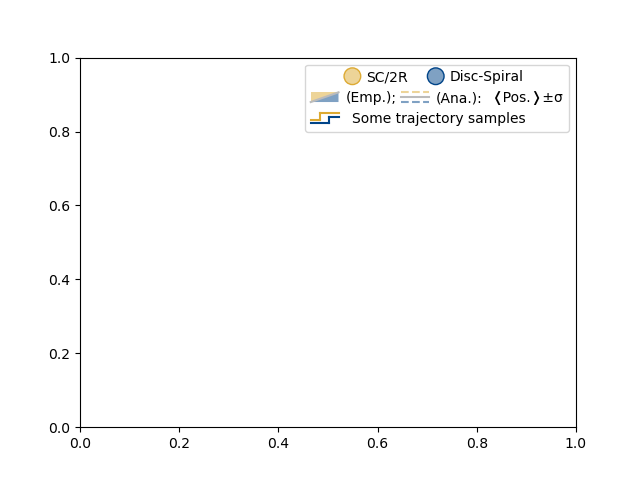

In [240]:
import matplotlib as mpl

yellow = '#DDAA33'
blue = '#004488'

fig, ax = plt.subplots()

# Empty classes for handlers in legend, all the handlers visuals are manually
# created


    class Models():
        pass


    class Sigmas():
        pass


    class Trajectories():
        pass

    class ModelsHandler:
        def legend_artist(self, legend, orig_handle, fontsize, handlebox):
            x0, y0 = handlebox.xdescent, handlebox.ydescent
            width, height = handlebox.width, handlebox.height

            x0 = width
            sc2r_circle = mpl.patches.Circle(
                (x0 + width/2, height/2), 0.6*fontsize, facecolor='#DDAA3380',
                edgecolor='#DDAA33', transform=handlebox.get_transform())
            sc2r_text = mpl.text.Text(x=x0 + width, y=0, text='SC/2R')

            disc_spiral_circle = mpl.patches.Circle(
                (x0 + width + 5*fontsize, height/2), 0.6*fontsize, facecolor='#00448880',
                edgecolor='#004488', transform=handlebox.get_transform())
            disc_spiral_text = mpl.text.Text(x=x0 + 1.5*width + 5*fontsize, y=0,
                                            text='Disc-Spiral')

            handlebox.width *= 8.7  # Width of full legend handled by this parameter
            handlebox.add_artist(sc2r_circle)
            handlebox.add_artist(sc2r_text)
            handlebox.add_artist(disc_spiral_circle)
            handlebox.add_artist(disc_spiral_text)
            return [sc2r_circle, sc2r_text, disc_spiral_circle, disc_spiral_text]


    class SigmasHandler:
        def legend_artist(self, legend, orig_handle, fontsize, handlebox):
            x0, y0 = handlebox.xdescent, handlebox.ydescent
            width, height = handlebox.width, handlebox.height

            # Empirical
            upper_triangle_xy = np.array([[0, 0], [0, height], [width, height]])
            upper_triangle = mpl.patches.Polygon(
                upper_triangle_xy, closed=True, facecolor='#DDAA3380',
                edgecolor='#00000000', transform=handlebox.get_transform())
            lower_triangle_xy = np.array([[0, 0], [width, height], [width, 0]])
            lower_triangle = mpl.patches.Polygon(
                lower_triangle_xy, closed=True, facecolor='#00448880',
                edgecolor='#00000000', transform=handlebox.get_transform())
            empirical_line = mpl.lines.Line2D(
                [0, width], [0, height], color='#BBBBBB')
            empirical_text = mpl.text.Text(x=width + 0.5*fontsize, y=0,
                                        text='(Emp.);')

            # Analytical
            x0 = width + 4.5*fontsize
            upper_analytical_line = mpl.lines.Line2D(  # SC2R std
                [x0, x0 + width], [height, height], linestyle='--', color='#DDAA33', alpha=0.5)
            middle_analytical_line = mpl.lines.Line2D(  # Average velocity
                [x0, x0 + width], [height/2, height/2], color='#BBBBBB')
            lower_analytical_line = mpl.lines.Line2D(  # Disc-Spiral std
                [x0, x0 + width], [0, 0], linestyle='--', color='#00448880', alpha=0.5)
            analytical_text = mpl.text.Text(x=2*width + 5*fontsize, y=0,
                                            text='(Ana.):')

            text = mpl.text.Text(x=2*width + 9*fontsize, y=0, text='❬Pos.❭±σ')

            handlebox.add_artist(upper_triangle)
            handlebox.add_artist(lower_triangle)
            handlebox.add_artist(empirical_line)
            handlebox.add_artist(empirical_text)
            handlebox.add_artist(upper_analytical_line)
            handlebox.add_artist(middle_analytical_line)
            handlebox.add_artist(lower_analytical_line)
            handlebox.add_artist(analytical_text)
            handlebox.add_artist(text)
            return upper_triangle


    class TrajectoriesHandler:
        def legend_artist(self, legend, orig_handle, fontsize, handlebox):
            x0, y0 = handlebox.xdescent, handlebox.ydescent
            width, height = handlebox.width, handlebox.height

            sc2r_1 = mpl.lines.Line2D(
                [0, width/3], [height/3, height/3], color='#DDAA33')
            sc2r_2 = mpl.lines.Line2D(
                [width/3, width/3], [height/3, height], color='#DDAA33')
            sc2r_3 = mpl.lines.Line2D(
                [width/3, width], [height, height], color='#DDAA33')

            disc_spiral_1 = mpl.lines.Line2D(
                [0, 2*width/3], [0, 0], color='#004488')
            disc_spiral_2 = mpl.lines.Line2D(
                [2*width/3, 2*width/3], [0, 2*height/3], color='#004488')
            disc_spiral_3 = mpl.lines.Line2D(
                [2*width/3, width], [2*height/3, 2*height/3], color='#004488')
            
            text = mpl.text.Text(x=1.5*width + 0*fontsize, y=0, text='Some trajectory samples')

            handlebox.add_artist(sc2r_1)
            handlebox.add_artist(sc2r_2)
            handlebox.add_artist(sc2r_3)
            handlebox.add_artist(disc_spiral_1)
            handlebox.add_artist(disc_spiral_2)
            handlebox.add_artist(disc_spiral_3)
            handlebox.add_artist(text)


    plt.legend(
        # The legend elements fully fill a column before filling the next column
        # Therefore, the elements are added in this (weird) order
        [Models(), Sigmas(), Trajectories()], ['', '', ''],
        handler_map={
            Models: ModelsHandler(), Sigmas: SigmasHandler(),
            Trajectories: TrajectoriesHandler()},
        ncols=1
    )
    plt.show()

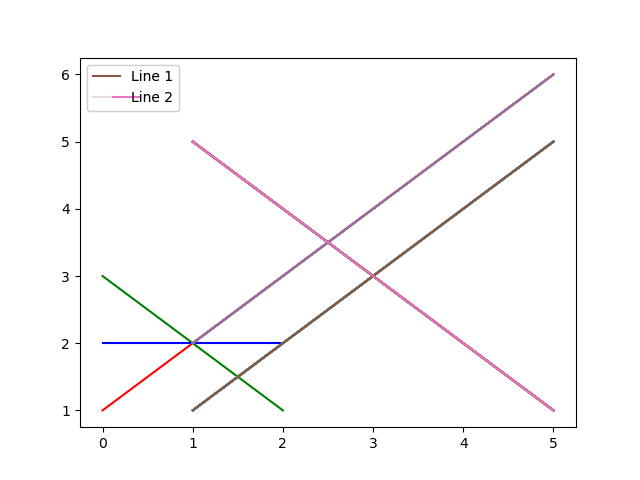

In [87]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.transforms import Affine2D

class HandlerIndent(HandlerLine2D):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        artists = HandlerLine2D.create_artists(self, legend, orig_handle,
                                               xdescent, ydescent,
                                               width, height, fontsize, trans)
        # Shift all artists to the right
        for artist in artists:
            artist.set_transform(artist.get_transform() + Affine2D().translate(width, 0))
        return artists

# Create some data
x = [1, 2, 3, 4, 5]
y1 = [1, 2, 3, 4, 5]
y2 = [5, 4, 3, 2, 1]

# Plot the data
line1, = plt.plot(x, y1, label='Line 1')
line2, = plt.plot(x, y2, label='Line 2')

# Create a legend with the custom handler
plt.legend(handles=[line1, line2], handler_map={line2: HandlerIndent()})

# Show the plot
plt.show()